In [1]:
import os
from random import random, sample

import evaluate
import numpy as np
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import (
    AdamW,
    DataCollatorForLanguageModeling,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    get_linear_schedule_with_warmup,
    Trainer, TrainingArguments
)


class TextDataset(Dataset):
    def __init__(self, text_file, block_size=256):
        self.tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

        self.block_size = block_size
        self.pad = self.tokenizer.encode(self.tokenizer.eos_token)[0]
        self.data = {
            'train': [],
            'validation': []
        }
        self.data['train'] = self.generate_dateset(text_file)
        self.data['validation'] = self.generate_dateset(
            text_file, eval=True, split=0.1)

    def generate_dateset(self, text_file, eval=False, split=0.1):
        data = []
        with open(text_file, "r", encoding="utf-8") as f:
            text = f.read().split("<BREAK>")
            if eval:
                text = sample(text, int(len(text)*split))

        input_ids = []
        attention_mask = []
        for t in text:
            input_ids.extend(self.tokenizer.encode(t))
            attention_mask.extend([1 for i in range(len(input_ids))])
        input_ids = self.pad_list(input_ids)
        attention_mask = self.pad_list(attention_mask)
        id_chunks = list(self.chunks(input_ids, self.block_size))
        attm_chunks = list(self.chunks(attention_mask, self.block_size))

        for id, mask in zip(id_chunks, attm_chunks):
            data.append({
                'input_ids': torch.tensor(id),
                'attention_mask': torch.tensor(mask),
                'labels': torch.tensor(id.copy())
            })
        return data
    
    def pad_list(self, input_ids):
        padding = self.block_size - (len(input_ids) % self.block_size)
        _ = [input_ids.append(self.pad) for _ in range(padding)]
        return input_ids

    def chunks(self, lst, n):
        """Yield successive n-sized chunks from lst."""
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]


def group_texts(examples, block_size=1024):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i: i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [15]:
# Create Tokenizer and Model objects
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained("gpt2")
block_size = 512
dataset = TextDataset("corpus.txt", block_size=block_size)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-8)



In [16]:
train_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)
train_dataloader = DataLoader(
    dataset["train"],
    batch_size=block_size,
    pin_memory=True,
    shuffle=True,
    collate_fn=train_collator,
)
eval_dataloader = DataLoader(
    dataset["validation"],
    batch_size=block_size,
    pin_memory=True,
    shuffle=True,
    collate_fn=train_collator,
)

In [17]:
torch.cuda.empty_cache()

In [18]:
model_checkpoint = "ethical"
model_name = model_checkpoint.split("/")[-1]
training_args = TrainingArguments(
    f"{model_name}-finetuned-gpt2",
    evaluation_strategy="epoch",
    learning_rate=1e-6,
    weight_decay=0.01,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=15,
    
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    optimizers=(optimizer, None),
    
)

In [19]:
trainer.train(
    resume_from_checkpoint=True)

  0%|          | 0/129 [00:00<?, ?it/s]

  0%|          | 0/4785 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 3.286198616027832, 'eval_runtime': 0.8302, 'eval_samples_per_second': 38.545, 'eval_steps_per_second': 38.545, 'epoch': 10.0}
{'loss': 3.3067, 'learning_rate': 5.370950888192268e-06, 'epoch': 10.97}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 3.2520198822021484, 'eval_runtime': 0.8348, 'eval_samples_per_second': 38.331, 'eval_steps_per_second': 38.331, 'epoch': 11.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 3.229323625564575, 'eval_runtime': 0.8531, 'eval_samples_per_second': 37.509, 'eval_steps_per_second': 37.509, 'epoch': 12.0}
{'loss': 3.2592, 'learning_rate': 3.2810867293625914e-06, 'epoch': 12.54}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 3.211854934692383, 'eval_runtime': 0.8528, 'eval_samples_per_second': 37.524, 'eval_steps_per_second': 37.524, 'epoch': 13.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 3.2013602256774902, 'eval_runtime': 0.8474, 'eval_samples_per_second': 37.762, 'eval_steps_per_second': 37.762, 'epoch': 14.0}
{'loss': 3.2138, 'learning_rate': 1.1912225705329155e-06, 'epoch': 14.11}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 3.1971094608306885, 'eval_runtime': 0.8284, 'eval_samples_per_second': 38.63, 'eval_steps_per_second': 38.63, 'epoch': 15.0}
{'train_runtime': 216.0371, 'train_samples_per_second': 22.149, 'train_steps_per_second': 22.149, 'train_loss': 1.213298049017927, 'epoch': 15.0}


TrainOutput(global_step=4785, training_loss=1.213298049017927, metrics={'train_runtime': 216.0371, 'train_samples_per_second': 22.149, 'train_steps_per_second': 22.149, 'train_loss': 1.213298049017927, 'epoch': 15.0})

In [20]:
del model
del trainer
torch.cuda.empty_cache()

In [21]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer, set_seed

In [23]:
model = AutoModelForCausalLM.from_pretrained("ethical-finetuned-gpt2\checkpoint-4500")
input = tokenizer.encode("Artificial Intelligence has societal", return_tensors="pt")


In [24]:
input

tensor([[ 8001,  9542,  9345,   468, 26877]])

In [25]:

generator = pipeline('text-generation', model=model, tokenizer=tokenizer)
set_seed(42)

In [26]:
generator("every lived experience of the world", max_length=50, num_return_sequences=5)


C:\Users\Travis Weston\AppData\Roaming\Python\Python39\site-packages\transformers\generation\utils.py:1201: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'every lived experience of the world: what that experience represents." This is not a problem for Bajorans with marginalized backgrounds, but those who are able and willing to work toward making a difference: the whole concept of marginalization isn\'t only unproductive'},
 {'generated_text': 'every lived experience of the world may, or may not, differ from the real world. Factors include social, economic and institutional factors. The social, biological, psychological, philosophical, philosophical, scientific, and technological systems of measurement have been able to make'},
 {'generated_text': 'every lived experience of the world, then there must be some kind of thing that can be said as meaningful to these questions. We have to be able to talk literally about all the lived experiences of the world, and we have to have a sense of'},
 {'generated_text': 'every lived experience of the world, one way i can easily tell you is that, frankly, the people who make up the

In [13]:
generator("every lived experience of the world", max_length=50, num_return_sequences=5)

C:\Users\Travis Weston\AppData\Roaming\Python\Python39\site-packages\transformers\generation\utils.py:1201: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'every lived experience of the world: what that experience represents." This is not a problem for any single “person", as John Locke would have it, for every “human mind" to be exactly the same, or at least to be the'},
 {'generated_text': 'every lived experience of the world may, or may not, differ from the real world. But we should not forget that there are some places in the world in which we live in which we know very little about the world, some situations in which we'},
 {'generated_text': 'every lived experience of the world, then there must be some kind of thing that can be said as meaningful to these questions. We have to be able to talk literally about these things; to know that they exist, and to believe them to exist in'},
 {'generated_text': 'every lived experience of the world, one way i can easily tell you is that, frankly, the people who make up the majority of these systems and how they process and use information, are probably right-wing and prejud

In [27]:
generator("", max_length=50, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'The impact of technology on society, on humanity and the future of humanity is always shifting. Each of these shifts will have unintended long-term consequences, each of the technologies involved will change both the way people see this world and the way society and technology'},
 {'generated_text': 'The impact of technology on society and on the world will continue to play out throughout the years. But while technology creates opportunities for change and greater freedom, it also erodes the foundations upon which society has stood. So here are five steps toward making a'},
 {'generated_text': 'The impact of technology on society will be very small. The impacts of innovation will increase as the amount of human knowledge is vastly reduced and our brains radically improved, and we are being built into new interfaces and interfaces with technologies that already degrade and destroy us'},
 {'generated_text': 'The impact of technology on society has continued, with ant

In [ ]:
model(input)

# How do Large Language models work

## Embeddings 

In [79]:
# Define two sentences to compare the embeddings of
sentence1 = "People are subject to the same moral obligations in virtual worlds as they are in the physical world."
sentence2 = "It is a moral obligation to ensure that the use of artificial intelligence does not infringe rights."
sentence3 = "People are subject to the same moral obligations in virtual worlds as they are in the physical world."
sentence4 = "It is a moral obligation to ensure that the use of artificial intelligence does not infringe rights."

: 

### Load a pretrained tokenizer from Huggingface

In [46]:
# Create Tokenizer and Model objects
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

In [47]:
embeddings1 = tokenizer.encode(sentence1, return_tensors="np")
embeddings2 = tokenizer.encode(sentence2, return_tensors="np")
embeddings3 = tokenizer.encode(sentence3, return_tensors="np")
embeddings4 = tokenizer.encode(sentence4, return_tensors="np")

array([[ 8061,   389,  2426,   284,   262,   976,  6573, 13675,   287,
         7166, 11621,   355,   484,   389,   287,   262,  3518,   995,
           13]])

In [48]:
embeddings2 = tokenizer.encode(sentence2, return_tensors="np")
embeddings2

array([[ 1026,   318,   257,  6573, 12990,   284,  4155,   326,   262,
          779,   286, 11666,  4430,   857,   407, 14020,    68,  2489,
           13]])

### Each number in the list of embeddings represents a word in a dictionary of words

In [58]:
# loop through the embeddings and print the decoded text
tokens1 = []
for i in range(len(embeddings1[0])):
    print(tokenizer.decode(embeddings1[0][i]).strip())
    tokens1.append(tokenizer.decode(embeddings1[0][i]).strip())
    

People
are
subject
to
the
same
moral
obligations
in
virtual
worlds
as
they
are
in
the
physical
world
.


In [77]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE


In [54]:
embeddings1[:,0]

array([8061])

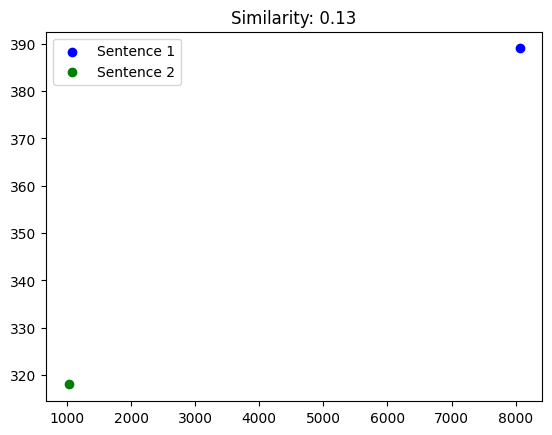

In [53]:
# Calculate cosine similarity between the two embeddings
similarity = cosine_similarity(embeddings1.reshape(1,-1), embeddings2.reshape(1,-1))

# Plot the embeddings
fig, ax = plt.subplots()
ax.scatter(embeddings1[:,0], embeddings1[:,1], color='blue', label='Sentence 1')
ax.scatter(embeddings2[:,0], embeddings2[:,1], color='green', label='Sentence 2')
ax.set_title(f'Similarity: {round(similarity[0][0], 2)}')
ax.legend()
plt.show()

In [64]:
embeddings1[0].reshape(1,-1)

array([[ 8061,   389,  2426,   284,   262,   976,  6573, 13675,   287,
         7166, 11621,   355,   484,   389,   287,   262,  3518,   995,
           13]])

In [71]:
embs = np.stack((embeddings1[0], embeddings2[0]), axis=0)

In [74]:
embs[0]

8061

In [78]:
# Reduce the dimensionality of the embeddings to 3 using PCA
pca = TSNE(n_components=3)
reduced_embeddings = pca.fit_transform(embs[0])

ValueError: perplexity must be less than n_samples

In [69]:


# Plot the embeddings in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, word in enumerate(tokens1):
    x, y, z = reduced_embeddings[i,:]
    ax.scatter(x, y, z, color='blue')
    ax.text(x, y, z, word, fontsize=10)
plt.show()

ValueError: n_components=3 must be between 0 and min(n_samples, n_features)=2 with svd_solver='full'

In [8]:
with open("corpus.txt", "r", encoding="utf-8") as f:
    text = f.read().split("<BREAK>")

In [10]:
int(len(text) * 0.2)

590

In [ ]:
Dataset.from_

In [ ]:
sample(text, int(len(text) * 0.2))